<a href="https://colab.research.google.com/github/Anushka-Swami/Ybi/blob/main/1_preprocess_for_one_audiofile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Emotion Recognition (Classification) in real-time using Deep LSTM layers**
### ***Data preprocess representation for a single audio file***
---

### Final project (B.Sc. requirement)  
Development by **Meidan Greenberg & Linoy Hadad.**

Instructor: **Dr. Dima Alberg**

Industial Engineering and Management dept.

SCE Collage, Israel.





# **LIBRARIES & GOOGLE AUTH**

In [29]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [30]:
%%capture
!pip install pydub
!pip install noisereduce

In [31]:
%%capture
import os
import numpy as np

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import matplotlib.pyplot as plt
from librosa import display
import IPython.display as ipd

# **DATA PREPROCESS REPRESENTATION**
This notebook present the data preprocessing for a single audio file.
The preprocess is described in the following diagram:
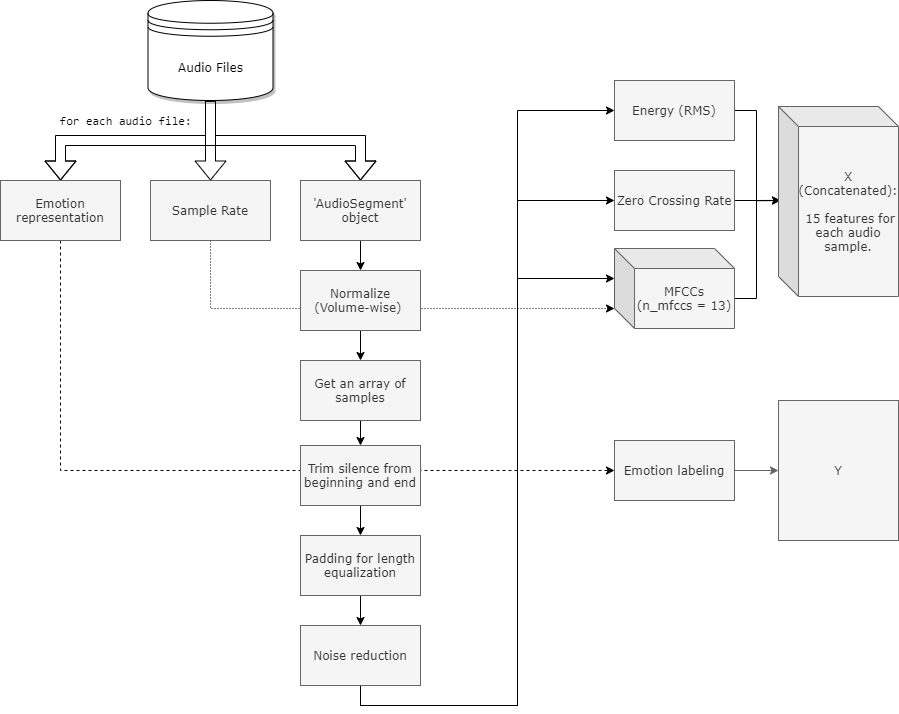

## **Diagram Explanation**
In general, The following data is extracted from each audio file:
1.   **Emotion representation**

    *   RAVDESS: The filename contains a number that represents an emotion, e.g. 03 is happy.
    *   TESS: The filename contains a direct representation of an emotion, e.g 'happy'.


2.   **Sample Rate**: number of audio samples per second. RAVDESS database was recorded in 48kHz, and the TESS database was recorded in 22.5kHz.

3. **The audio** is processed in the following order:


*   'AudioSegment' instance: The audio is loaded to an object by the library 'AudioSegment'.
*   Normalization: Each 'AudioSegment' object is normalized to + 5.0 dBFS.

*   Transforming the object to an array of samples is crucial for the rest of the preprocessing.
*   Trimming the silence in the beginning and the end, to get rid of unnecessary data.
*   Padding every audio file to the same length, for length equalization.
*   Noise reduction is being performed.
---


## **Audio preprocess for a single file**

In [32]:
import zipfile
zip_path = '/content/drive/My Drive/kaggle_datasets/Ravdess.zip'
extract_path = '/content/datasets/ravdess/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping complete!")


Unzipping complete!


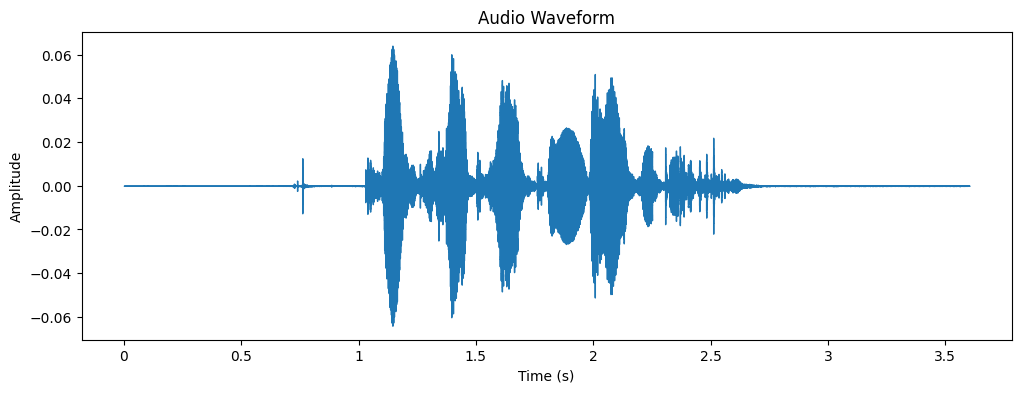

In [33]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define the file path to the audio
path = '/content/datasets/ravdess/Actor_02/03-01-01-01-01-02-02.wav'

# Load the audio file with librosa
x, sr = librosa.load(path, sr=None)

# Visualize the waveform of the audio
plt.figure(figsize=(12, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


In [34]:
# Define file path for a single file.
path = '/content/datasets/ravdess/Actor_02/03-01-01-01-01-02-02.wav'

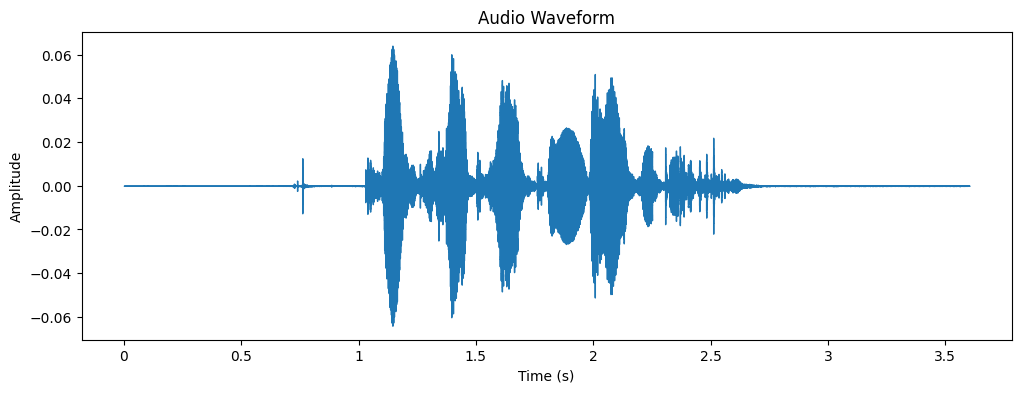

In [35]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define the file path to the audio (from the extracted folder)
path = '/content/datasets/ravdess/Actor_02/03-01-01-01-01-02-02.wav'

# Load the audio file with librosa
x, sr = librosa.load(path, sr=None)

# Visualize the waveform of the audio using waveshow
plt.figure(figsize=(12, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

The actual audio as well as the 'y' axis range suggests that the initial audio is very low-volumed. This can interfere with the feature extraction validity.




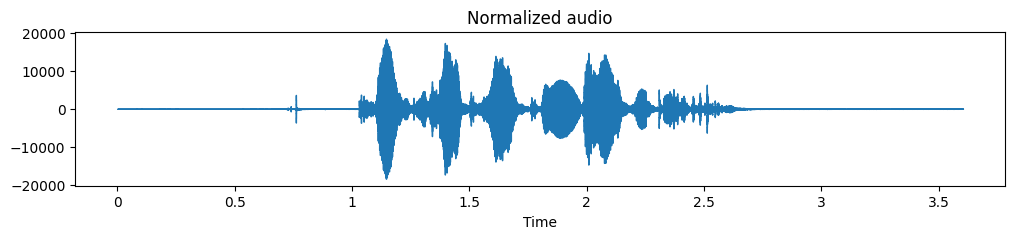

In [36]:
# 2. Normalize to +5.0 dBFS, Transform audio signals to an array.

normalizedsound = effects.normalize(rawsound, headroom = 5.0)
normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

plt.figure(figsize=(12,2))
# Replace waveplot with waveshow
librosa.display.waveshow(normal_x, sr=sr) # sr=sr is used to explicitly pass the sample rate
plt.title('Normalized audio')

normalizedsound

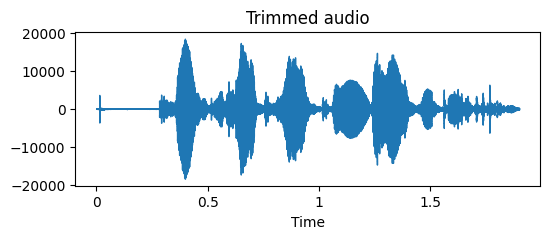

In [37]:
# 3. Trim silence in the beginning and end.

xt, index = librosa.effects.trim(normal_x, top_db = 30)

plt.figure(figsize=(6,2))
# Pass 'sr' as a keyword argument
librosa.display.waveshow(xt, sr=sr)
plt.title('Trimmed audio')

ipd.display(ipd.Audio(data = xt, rate=sr))

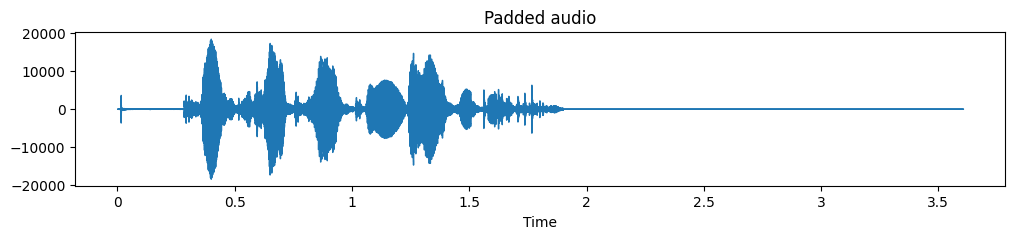

In [38]:
# 4. Right-side padding for length equalization.
#    173056 = maximum lengthed audio (the extraction of this value is performed in the "SpeechEmotionRecognion_Model" notebook.)

padded_x = np.pad(xt, (0, 173056-len(xt)), 'constant')

plt.figure(figsize=(12,2))
# Replace waveplot with waveshow
librosa.display.waveshow(padded_x, sr=sr)  # sr=sr is used to explicitly pass the sample rate
plt.title('Padded audio')

ipd.display(ipd.Audio(data = padded_x, rate=sr))

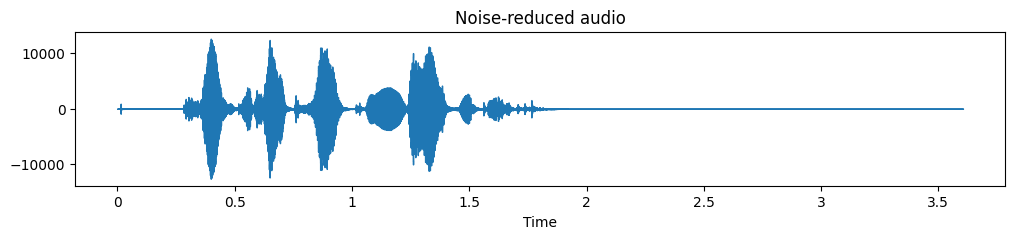

In [39]:
# 5. Noise reduction
#    Note: although there is no noise to reduce from RAVDESS nor TESS databases, reduce_noise function by noisereduce library attributes a uniform stamper to the audio files.
# Replace 'audio_clip' and 'noise_clip' with 'y' and 'y_noise' respectively
# Include the sample rate 'sr' using the 'sr' argument

# Remove the 'verbose' argument
final_x = nr.reduce_noise(y=padded_x,
                          y_noise=padded_x,
                          sr=sr) # Pass sample rate


plt.figure(figsize=(12,2))
# Replace waveplot with waveshow
librosa.display.waveshow(final_x, sr=sr)  # sr=sr is used to explicitly pass the sample rate
plt.title('Noise-reduced audio')

ipd.display(ipd.Audio(data = final_x, rate=sr))

## **Features extraction for a single file**
The selected features being extracted with *librosa* for the speech emotion recognition model are:

1.   Energy - Root Mean Square (RMS)
2.   Zero Crossed Rate (ZCR)
3.   Mel-Frequency Cepstral Coefficients (MFCCs)

With frame_length = 2048, hop_lentgh = 512.

Explanation:

Every 2048 samples (sequence of ~0.058 seconds on average) are being analyzed and translated to 4 sequential feature values (2048 / 512 = 4).

In total, for an audio file lengthed 173056 samples, considering the last sample, 339 sequential values are returned for each feature  (173056+1 / 512 = 339).

In [40]:
f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square (RMS)
print('Energy shape:', f1.shape)
f2 = librosa.feature.zero_crossing_rate(y=final_x, frame_length=frame_length, hop_length=hop_length) # Zero Crossed Rate (ZCR)
print('ZCR shape:', f2.shape)
f3 = librosa.feature.mfcc(y=final_x, sr=sr, S=None, n_mfcc=13, hop_length = hop_length) # MFCCs
print('MFCCs shape:', f3.shape)

Energy shape: (1, 339)
ZCR shape: (1, 339)
MFCCs shape: (13, 339)


# **CONCLUSIONS**

This notebook presents a **partial** preprocess for one audio file.
The audio preprocess has been executed as well as the extraction of the sample rate, and feature extraction has been shown as well. The full preprocess is executed in "2_model" notebook.

All features have 339 time-steps, thus, all of the data is equally lengthed, as well as homogeneous.